<a href="https://colab.research.google.com/github/SoSavage321/MachineLearningLab7/blob/main/Lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1: Implementing a Majority Vote Classifier**

**Step 1.2: Implement Majority Voting Classifier**

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import _name_estimators

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """A majority vote ensemble classifier"""

    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """Fit classifiers"""
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """Predict class labels"""
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                axis=1, arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """Predict class probabilities"""
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

**Step 1.3: Prepare the Iris Dataset**

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load Iris dataset
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

**Step 1.4: Train Individual Classifiers**

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold  # Used for consistency

# Create individual classifiers
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

# Create pipeline with standardization
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation:\n')

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=skf, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.09) [Logistic regression]
ROC AUC: 0.88 (+/- 0.07) [Decision tree]
ROC AUC: 0.89 (+/- 0.10) [KNN]


**Step 1.5: Create and Evaluate Majority Voting Classifier**

In [7]:
from sklearn.metrics import roc_auc_score  # Added to fix NameError

# Create majority rule classifier
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    if clf == mv_clf:
        # Manual CV for consistency and to avoid NaN in ROC AUC
        scores = []
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]
            clf_clone = clone(clf)
            clf_clone.fit(X_tr, y_tr)
            proba_val = clf_clone.predict_proba(X_val)[:, 1]
            score = roc_auc_score(y_val, proba_val)
            scores.append(score)
        print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (np.mean(scores), np.std(scores), label))
    else:
        scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=skf, scoring='roc_auc')
        print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.09) [Logistic regression]
ROC AUC: 0.88 (+/- 0.07) [Decision tree]
ROC AUC: 0.89 (+/- 0.10) [KNN]
ROC AUC: 0.97 (+/- 0.04) [Majority voting]


# **Part 2: Bagging - Building Ensemble from Bootstrap Samples**

**Step 2.2: Prepare Wine Dataset**

In [8]:
from sklearn.datasets import load_wine

wine = load_wine()
df_wine = pd.DataFrame(wine.data, columns=wine.feature_names)
df_wine['Class label'] = wine.target
df_wine = df_wine[df_wine['Class label'] != 0]  # Drop class 0 (equiv. to 1 in original)
y = df_wine['Class label'].values
X = df_wine[['alcohol', 'od280/od315_of_diluted_wines']].values
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

**Step 2.3: Implement Bagging Classifier**

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

# Create decision tree classifier
tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=None)

# Train and evaluate individual decision tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

# Create bagging classifier
bag = BaggingClassifier(estimator=tree, n_estimators=500,
                        max_samples=1.0, max_features=1.0,
                        bootstrap=True, bootstrap_features=False,
                        n_jobs=1, random_state=1)

# Train bagging
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f' % (bag_train, bag_test))

Decision tree train/test accuracies 1.000/0.833
Bagging train/test accuracies 1.000/0.917


**Step 2.4: Visualize Decision Boundaries**

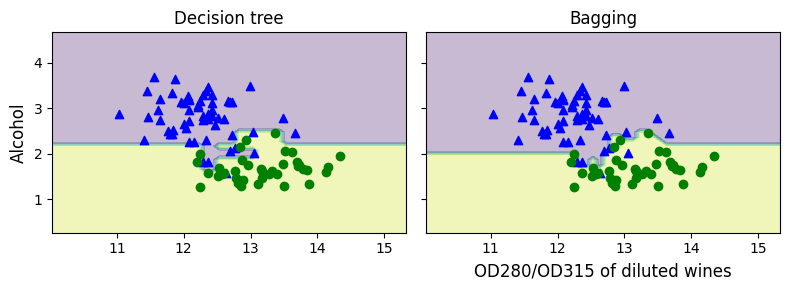

In [10]:
import matplotlib.pyplot as plt

# Create mesh grid for plotting
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8, 3))

for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.xlabel('OD280/OD315 of diluted wines', fontsize=12)
plt.tight_layout()
plt.show()

# **Part 3: Adaptive Boosting (AdaBoost)**

**Step 3.2: Implement AdaBoost Classifier**

In [11]:
from sklearn.ensemble import AdaBoostClassifier

# Create decision tree stump
tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=1)

# Train individual decision tree stump
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree stump train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

# Create AdaBoost classifier
ada = AdaBoostClassifier(estimator=tree, n_estimators=500,
                         learning_rate=0.1, random_state=1)

# Train AdaBoost classifier
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f' % (ada_train, ada_test))

Decision tree stump train/test accuracies 0.916/0.875
AdaBoost train/test accuracies 0.968/0.917


**Step 3.3: Analyze AdaBoost Error Convergence**

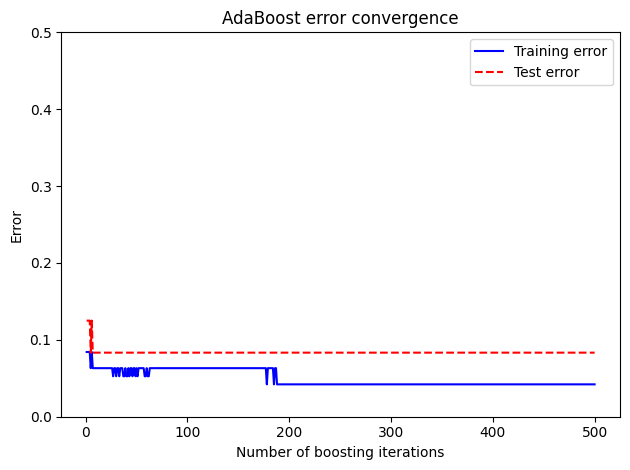

In [12]:
# Plot error convergence for AdaBoost
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, random_state=1),
                         n_estimators=500, learning_rate=0.1, random_state=1)

ada.fit(X_train, y_train)
ada_train_err = []
ada_test_err = []

for y_train_pred, y_test_pred in zip(ada.staged_predict(X_train), ada.staged_predict(X_test)):
    ada_train_err.append(1 - accuracy_score(y_train, y_train_pred))
    ada_test_err.append(1 - accuracy_score(y_test, y_test_pred))

plt.plot(range(1, len(ada_train_err) + 1), ada_train_err, label='Training error', color='blue', linestyle='-')
plt.plot(range(1, len(ada_test_err) + 1), ada_test_err, label='Test error', color='red', linestyle='--')
plt.xlabel('Number of boosting iterations')
plt.ylabel('Error')
plt.legend(loc='upper right')
plt.ylim(0, 0.5)
plt.title('AdaBoost error convergence')
plt.tight_layout()
plt.show()